# <center> PROCESAMIENTO DIGITAL DE SEÑALES DE AUDIO</center>
## <center> Reverberador con filtros digitales</center>      

In [1]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

import IPython.display as ipd


**NOTA:** *Las siguientes dos celdas solo son necesarias para descargar el archivo de ejemplo. Ignórelas si va a trabajar con sus propios archivos de audio.*

In [2]:
!pip install wget

In [3]:
import wget

### Descripción

Este ejercicio sirve para estudiar una estructura de filtros digitales para construir un **reverberador** del tipo propuesto por [Moorer], tal como se describe en el libro de [Steiglitz].

La idea de la estrcutura se representa en el siguiente diagrama. Consiste en seis filtros peine en paralelo, cada uno con sus diferentes parámetros, que modelan las reflexiones en el recinto. El camino directo con ganancia K representa la onda directa. El filtro pasa-todos se incluye para la *difusión* de las reflexiones. Los filtros peine se refinan incluyendo un filtro pasabajos (IIR de primer orden) en el bucle, que modela la absorción del sonido, las frecuencias mas altas se absorben mas rápidamente.

![alt text](./figures/moorer.png "Moorer reverb")


.. [Moorer] Moorer, J. A. (1979). *About this reverberation business*. Computer Music Journal, 3(2):13–28.

.. [Steiglitz] Steiglitz, K. (1996). *Digital Signal Processing Primer: With Applications to Digital Audio and Computer Music.* Prentice Hall.


### Cómo correr el notebook
Se puede bajar y correr el notebook de forma local en una computadora.

O también se puede correr en Google Colab usando el siguiente enlace. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/notebooks/audioDSP-moorer_reverb_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Filtro peine

La siguiente función implementa un filtro peine, siguiendo el esquema que se presenta a continuación. Estudie el código y responda las siguientes preguntas.

![alt text](./figures/echo.png "Echo diagram")

1. ¿Cómo describiría a este filtro peine? ¿Qué tipo de realimentación tiene?
2. ¿Cómo es su respuesta al impulso? ¿Y su respuesta en frecuencia?
3. ¿Cómo modificaría este filtro para agregar un pasabajos en cada iteración?

In [4]:
def comb_filter(x, L, R):
    """
    comb filter   

    Parameters
    ----------
    x (numpy array)   : input audio waveform
    L (int)           : delay length in samples
    R (float)         : dumping factor

    Returns
    -------
    y (numpy array) : filtered audio waveform
    
    """
    # signal length
    N = x.size
    # output signal
    y = np.copy(x)
    # force L to be integer
    L = int(L)
    
    # compute ouput from filter equation
    for n in range(L,N):
        y[n] = x[n] + R**L * y[n-L]
        
    return y

Es un filtro peine Feedback, tiene realimentación positiva.

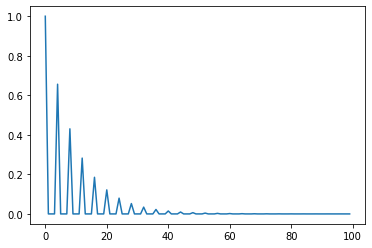

In [5]:
delta = np.zeros(100)
delta[0] = 1

y = comb_filter(delta, 4, 0.9)
plt.plot(y)
plt.show()

/Users/julianoflaherty/Documents/Facultad/AudioDSP/.venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


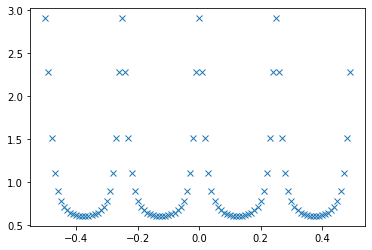

In [6]:
from scipy.fft import fft, fftfreq, fftshift

f_y = fft(y)
# f_y = fftshift(y)
w = fftfreq(f_y.size)

plt.plot(w, f_y, 'x')

Agregar un LPF en lazo abierto

### Reverberador

Complete el código de la siguiente función que implementa el reverberador, usando los filtros definidos anteriormente (por el momento no implemente el filtro pasa-todos).

In [7]:
def moorer_reverb(x, fs, t0=0.05, K=1.2, delays=[0.050, 0.056, 0.061, 0.068, 0.072, 0.078], rt60=1.5):
    """
    moorer reverb

    Parameters
    ----------
    x (numpy array)     : input audio waveform
    fs (int)            : sampling frequency in Hz
    t0 (float)          : pre-delay in seconds
    delays (list float) : delay line lengths (of comb filters) in seconds
    res_bw (float)      : reverberation time at zero-frequency (e.g., 1.5)

    Returns
    -------
    y (numpy array) : filtered audio waveform

    """
    # delays as numpy array
    ds = np.array(delays)
    # pre-delay in samples
    L0 = round(t0 * fs)
    # comb filter delays in samples
    Ls = np.round(ds * fs)
    # comb filter gains    
    Rs = 10**((-3.0*ds)/(rt60*fs))
    
    # pre-delay
    w0 = np.append(np.zeros(L0), x)
    x_out = np.append(x, np.zeros(L0))
    ws = np.zeros(w0.shape)
    
    # comb filters
    for ind in range(len(delays)): 
        # apply comb filter
        w = comb_filter(x_out, Ls[ind], Rs[ind])
        
        # sum comb filter output
        ws += w
        

    # all-pass filter delay
    L_ap = np.round(0.005 * fs)
    # all-pass filter gain
    g_ap5 = 0.7
        
    # allpass filter
    # ap = allpass(...)
    
    # produce output
    y = ws + K*x_out

    return y

### Prueba del reverberador

Pruebe el resultado del reverberador con una señal de audio de ejemplo. Ejecute el código y analice lo siguiente. 

1. ¿Se logra simular el efecto de reverberación? 
2. ¿Cuál es el efecto de cambiar la ganancia K?
3. ¿Cómo varía el resultado cambiando el tiempo de reverberación (rt60)?
4. Considere una menor cantidad de filtros peine. ¿Cuál es la mínima cantidad de filtros razonable?

In [8]:
# download audio file to use
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/ohwhere.wav?raw=true')

100% [........................................................] 392240 / 392240

'ohwhere (1).wav'

In [9]:
# load audio file from local path
fs, x = wavfile.read('./ohwhere.wav')

# play audio
ipd.Audio(x, rate=fs)

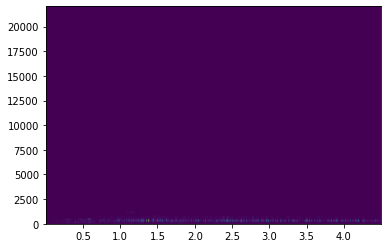

In [10]:
y = moorer_reverb(x, fs)
f, t, Sxx = signal.spectrogram(y, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.show()

In [11]:
ipd.Audio(y,rate=fs)

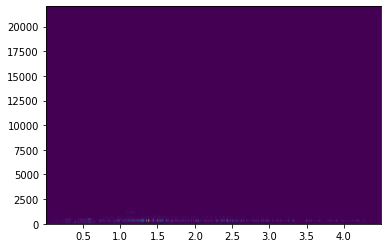

In [12]:
y = moorer_reverb(x, fs, rt60=0.5)
f, t, Sxx = signal.spectrogram(y, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.show()
ipd.Audio(y,rate=fs)

### Ejercicio: Filtro pasa-todos

Complete la siguiente función que implementa un filtro peine, siguiendo el esquema que se presenta a continuación. Modifique la implementación del filtro para incluir el filtro pasa-todos.

![alt text](./figures/all-pass.png "All-pass diagram")

In [14]:
def all_pass(x, L, a):
    """
    all-pass filter   

    Parameters
    ----------
    x (numpy array)   : input audio waveform
    L (int)           : delay length in samples
    R (float)         : dumping factor

    Returns
    -------
    y (numpy array) : filtered audio waveform
    
    """
    # signal length
    N = x.size
    # output signal
    y = np.copy(x)
    # force L to be integer
    L = int(L)
    
    # compute ouput from filter equation
    # y[n] - ay[n-1] = -ax[n] + x[n-1]
    
    for i in range(0, len(y)):
        y[i] = a*y[i-1] -a * x[i] + x[i-1]
    
    return y

### Ejercicio: Filtro pasa-bajos

Para refinar el modelo se utiliza un filtro pasabajos (IIR de primer orden) en el bucle del filtro peine. El filtro pasabajos modela que las frecuencias más altas se absorben más rápidamente. Modifique la implementación del filtro peine para incluir el pasabajos y analice su efecto en el resultado del reverberador.